# Generating Monet-Style Images with GANs

In this study various GAN models will be used to apply Monet art styles to photographs. This is the new "getting started" competition for GANs on [kaggle](https://www.kaggle.com/c/gan-getting-started/overview/). Previously, the GANs getting started competion was about generating dogs, linked [here](https://www.kaggle.com/c/generative-dog-images). I completed that project in last week's [assignment](https://github.com/CodebaseWes/Gans-Notebook/blob/main/Dogs.ipynb) and decided to do the new version for my final project.

In a GAN, a generator neural network is fed some kind of input and is tasked with converting that input into a counterfit output (e.g. a Monet painting). A discriminator neural network is then tasked with correctly identifying counterfit items. After the discriminator has been trained, it is then used to help the generator produce more realistic output and the cycle continues until it becomes difficult to differentiate between what is real and fake. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /root/.kaggle
!cp kaggle.json ../root/.kaggle
!ls ../root/.kaggle
!kaggle competitions download -c gan-getting-started
!unzip -q gan-getting-started.zip -d gan-getting-started

kaggle.json
 99% 364M/367M [00:02<00:00, 176MB/s]
100% 367M/367M [00:02<00:00, 147MB/s]


### Data Description

The data from this study can be found on [Kaggle](https://www.kaggle.com/competitions/gan-getting-started/data). The dataset comes in two parts: 1) A directory of 300 images of works by French painter Oscar-Claude Monet; 2) A directory of 7028 photographs. All these images have dimensions 256px x 256px and three color chanels (RGB). In addition, they are all JPG-encoded.

In [ ]:
#Very useful library for simplifying the GAN training process https://github.com/Ritvik19/pyradox-generative
!pip install pyradox-generative

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as showimg

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from pyradox_generative import CycleGAN


import pathlib
import time
from PIL import Image
import datetime
from sklearn import metrics as met
import cv2

from matplotlib import pyplot as plt
from IPython import display

from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import save_img
from sklearn.model_selection import train_test_split

## Data Cleaning and Exporatory Data Analysis

Let us begin with a verification procedure to ensure that the data are clean and ready to work with. Also included in this section is an exploratory data analysis that will give insight into how to proceed with building a high performing model.

In [ ]:
!ls gan-getting-started/monet_jpg/* | wc -l
!ls gan-getting-started/photo_jpg/* | wc -l

300
7038


In [ ]:
!ls -U gan-getting-started/monet_jpg/* | head -10

gan-getting-started/monet_jpg/000c1e3bff.jpg
gan-getting-started/monet_jpg/011835cfbf.jpg
gan-getting-started/monet_jpg/0260d15306.jpg
gan-getting-started/monet_jpg/049e293b93.jpg
gan-getting-started/monet_jpg/05144e306f.jpg
gan-getting-started/monet_jpg/052a77c020.jpg
gan-getting-started/monet_jpg/058f878b7c.jpg
gan-getting-started/monet_jpg/05b493ff42.jpg
gan-getting-started/monet_jpg/064487d630.jpg
gan-getting-started/monet_jpg/066fe4cbaa.jpg


In [ ]:
!ls gan-getting-started/photo_jpg/* | head -10

gan-getting-started/photo_jpg/00068bc07f.jpg
gan-getting-started/photo_jpg/000910d219.jpg
gan-getting-started/photo_jpg/000ded5c41.jpg
gan-getting-started/photo_jpg/00104fd531.jpg
gan-getting-started/photo_jpg/001158d595.jpg
gan-getting-started/photo_jpg/0033c5f971.jpg
gan-getting-started/photo_jpg/0039ebb598.jpg
gan-getting-started/photo_jpg/003aab6fdd.jpg
gan-getting-started/photo_jpg/003c6c30e0.jpg
gan-getting-started/photo_jpg/00479e2a21.jpg


In [ ]:
im = Image.open("gan-getting-started/monet_jpg/066fe4cbaa.jpg")
w, h = im.size
print("Width of Image: {}px\n Height of Monet Image: {}px".format(w,h))

Width of Image: 256px
 Height of Monet Image: 256px


In [ ]:
im = Image.open("gan-getting-started/photo_jpg/00479e2a21.jpg")
w, h = im.size
print("Width of Image: {}px\n Height of Photo: {}px".format(w,h))

Width of Image: 256px
 Height of Photo: 256px


The data appear to be clean. The dimensions, number and format of the images are what is expected. Next, let us view a sample of Monet paintings and photographs in order for us to examine the styles of the respective images.

In [ ]:
def get_imgs(path, batch_size):
    return tf.keras.preprocessing.image_dataset_from_directory(
    path, labels=None, batch_size=batch_size, seed=123)

In [ ]:
buffer_size = 256
batch_size = 15

monet_imgs = get_imgs("gan-getting-started/monet_jpg/", batch_size) 
photos  = get_imgs("gan-getting-started/photo_jpg/", batch_size) 

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


In [ ]:
samp_monet, samp_photos = next(iter(monet_imgs)), next(iter(photos))

The following are Monet paintings. There are a few features that stand out on a quick glance: 

1) Clouds and trees appear have consistent styles across paintings. 

2) Artificial structures (i.e. buildings and bridges) have more detail

3) Natural features such as trees and mountains lack a lot of detail

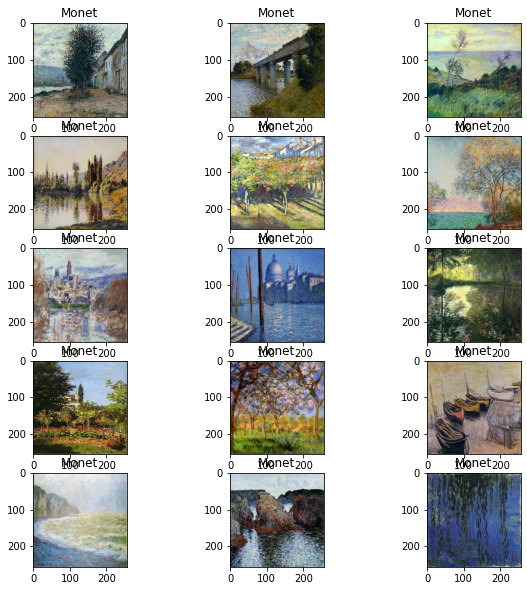

In [ ]:
plt.figure(figsize=(10,10))
for (i,img) in enumerate(samp_monet):
  plt.subplot(5, 3, i+1)
  plt.title("Monet")
  plt.imshow(img / 255.)

The following are regular photographs. The scenes and objects depicted in these photos are similar those in Monet paintings.

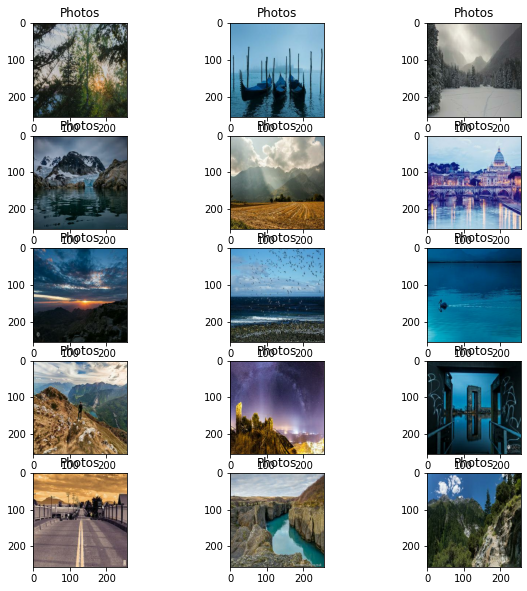

In [ ]:
plt.figure(figsize=(10,10))
for (i,img) in enumerate(samp_photos):
  plt.subplot(5, 3, i+1)
  plt.title("Photos")
  plt.imshow(img / 255.)

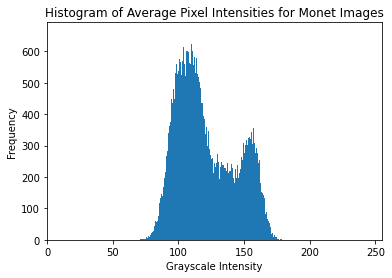

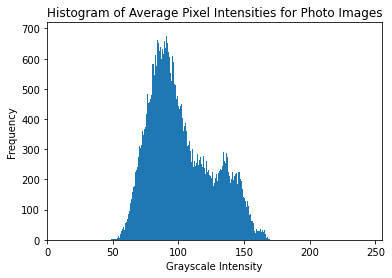

In [ ]:
monet_intensities = np.zeros(256*256)
for image in samp_monet:
    monet_intensities += np.array(image).mean(axis=2).flatten()

b, bins, patches = plt.hist(monet_intensities / len(samp_monet), 255)
plt.xlim([0,255])
plt.title("Histogram of Average Pixel Intensities for Monet Images")
plt.xlabel("Grayscale Intensity")
plt.ylabel("Frequency")
plt.show()

no_intensities = np.zeros(256*256)
for image in samp_photos:
  no_intensities += np.array(image).mean(axis=2).flatten()

b, bins, patches = plt.hist(no_intensities / len(samp_photos), 255)
plt.title("Histogram of Average Pixel Intensities for Photo Images")
plt.xlabel("Grayscale Intensity")
plt.ylabel("Frequency")
plt.xlim([0,255])
plt.show()

Above are grayscale intensity histograms associated with the sample of Monet paintings and photos. The distributions are very similar, peaking at around a 90 intensity value. The distribution associated with Monet paintings is bi-modal, with a second, shorter peak in intensity values at around 160.

### Data Transformation

For best results, the values in each color channel in all images should be transformed into a format the GAN models process. The range of values in each channel should be between -1 and 1. This cooresponds to range of the hyperbolic tangent function, which is the recommended output function for generator neural networks. Therefore, it is conventient to transform inputs for generators and discriminators to the aforementioned range of values because output from the generator will be fed to the discriminator.

Data augmentation is a useful way of boosting the generalization power of a dataset. I chose to enable tensorflow to randomly flip images along the vertical axis during model training.

In [ ]:
tfds.disable_progress_bar()
orig_img_size = (256, 256)
input_img_size = (256, 256, 3)

monet_imgs = get_imgs("gan-getting-started/monet_jpg/", batch_size) 
photos  = get_imgs("gan-getting-started/photo_jpg/", batch_size) 

def preprocess_train_image(img):
    img = tf.image.random_flip_left_right(img)
    img = normalize_img(img)
    return img

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

monet_imgs = (
    monet_imgs.map(preprocess_train_image)
)
photos = (
    photos.map(preprocess_train_image)
)

### Plan of Analysis

Based on the comparisions between the photos and Monet paintings, a GAN should be able to learn filters that can be applied to a photo to resemble a Monet painting. Because the intesity distributions between the classes of image are so similar, this should not be a difficult task.

## Model Architecture

A Cycle GAN uses two generators and two discriminators to convert images of two classes back and forth in order to train generators that can effectivelly transfer styles from one class of images to another. Below is the implementation of the architecture of the discriminators used in the Cycle GAN. It adheres to best practices (i.e leaky relu hidden layer activations, dropout and batch normalization). For sake of hyperparameter tuning, two different gans will be trained each using a different generator architecture. Once a superior architecture has been found, an ideal learning rate will be found through hyperparameter tuning.

In [ ]:

def build_disc(name):
  input = tf.keras.Input((256, 256, 3))

  x = tf.keras.layers.Conv2D(128, kernel_size=(5,5))(input)
  x = tf.keras.layers.LeakyReLU(0.2)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2))(input)
  x = tf.keras.layers.LeakyReLU(0.2)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(16, kernel_size=(3,3))(x)
  x = tf.keras.layers.LeakyReLU(0.2)(x)
  x = tf.keras.layers.Conv2D(8, kernel_size=(3,3))(x)
  x = tf.keras.layers.LeakyReLU(0.2)(x)
  x = tf.keras.layers.Conv2D(4, kernel_size=(3,3))(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation="relu")(x)
  x = tf.keras.layers.Dense(64, activation="relu")(x)
  out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  disc = tf.keras.Model(inputs=input, outputs=out, name = name)
  return disc
#build_disc("discriminator").summary()

The following generator implemenetation is very simple. Intuitively, this generator should learn which filters to apply to the photos to allow them to best mimic Monet paintings. Notice that the output activation is tanh, which returns values between -1 and 1.

In [ ]:
def build_gen1(name):
    inpt = keras.layers.Input(shape=(256, 256, 3))
    x = keras.layers.Conv2D(128, 3, activation="relu", padding="same")(inpt)
    
    x = keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    
    out = keras.layers.Conv2D(3, 3, activation="tanh", padding="same")(x)
    
    return keras.Model(inpt, out)
#build_gen2("gen2").summary()

The next generator architecture is slightly more complicated, with more layers, but fewer filters per layer. 

In [ ]:
def build_gen2(name):
    inpt = keras.layers.Input(shape=(256, 256, 3))
    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(inpt)
    
    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    
    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)

    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    
    out = keras.layers.Conv2D(3, 3, activation="tanh", padding="same")(x)
    
    return keras.Model(inpt, out)
#build_gen2("gen2").summary()

The following function comiles the generators and discriminators into a Cycle GAN and trains them using the provided images.

In [ ]:
def get_gan(paintings, photos, gen_g, gen_f, disc_x, disc_y, lr_g = 2e-4, lr_f = 2e-4, lr_x = 2e-4,
            lr_y = 2e-4, b_g = 0.5, b_f = 0.5, b_x = 0.5, b_y = 0.5, epocs = 15):
    gan = CycleGAN(
        generator_g = gen_g,
        generator_f = gen_f,
        discriminator_x = disc_x,
        discriminator_y = disc_y,
    )

    gan.compile(
        gen_g_optimizer=keras.optimizers.Adam(learning_rate=lr_g, beta_1=b_g),
        gen_f_optimizer=keras.optimizers.Adam(learning_rate=lr_f, beta_1=b_f),
        disc_x_optimizer=keras.optimizers.Adam(learning_rate=lr_x, beta_1=b_x),
        disc_y_optimizer=keras.optimizers.Adam(learning_rate=lr_y, beta_1=b_y),
    )
    
    for i in range(1, epocs+1):
        print("Epoc {}".format(i))
        gan.fit(
            tf.data.Dataset.zip((paintings, photos)),
        )
    return gan


## Results and Analysis

Let us train two models and compare the results. The outputs have been removed from this notebook since they add little value and clutter things up.

In [ ]:
gan1 = get_gan(
        paintings = monet_imgs,
        photos = photos,
        gen_g = build_gen1("gen_G"),
        gen_f = build_gen1("gen_F"),
        disc_x = build_disc("disc_X"),
        disc_y = build_disc("disc_Y"),
        epocs = 50,
)

In [ ]:
gan2 = get_gan(
        paintings = monet_imgs,
        photos = photos,
        gen_g = build_gen2("gen_G"),
        gen_f = build_gen2("gen_F"),
        disc_x = build_disc("disc_X"),
        disc_y = build_disc("disc_Y"),
        epocs = 50,
)

The losses associated with the generators and discriminators is displayed in the following table. It appears that the Gan1 model performed better given its loss metrics are generally lower.


|   | G_loss| F_loss| D_X_loss| D_Y_loss| |
|---|---|---|---|---|---|
| Gan1|   1.7521 |  1.4754  | 0.1324 | 0.0912  |  |   |   |
| Gan2|  2.1589  | 2.0498 |  0.1165 | 0.1287  |  |   |   |


In [ ]:
def save_imgs(good_gen, bat_size, limit, dir_name):
    os.system("mkdir {}".format(dir_name))
    os.system("rm {}/*.jpg".format(dir_name))

    photos = get_imgs("gan-getting-started/photo_jpg", bat_size)
    photos_it = iter(photos)

    i = 0
    for j in range(0, limit):
      batch = next(photos_it)
      to_monet = good_gen.predict(batch / 127.5 - 1)
      for img in to_monet:
        i += 1
        im = array_to_img(img)
        save_img('{}/img_{}.jpg'.format(dir_name, i), im)

In [ ]:
save_imgs(gan1.gen_G, 300, 1, "gen1")
save_imgs(gan2.gen_G, 300, 1, "gen2")

It can be difficult to tell how well the generated images resemble Monet paintings without sophisticated artistic training. One plausable metric is to observe how well a neural network model can differentiate between photographs and monet paintings.

In [ ]:
def train_inception(dir_name, epochs = 2, showMetrics = True):
    NUM_MONET = 300
    
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',  
        input_shape=(256, 256, 3),
        include_top=False) 
    base_model.trainable = True #dont want to train this yet

    x = base_model.output

    #my custom NN
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)


    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=["accuracy"])

    monet_imgs = get_imgs("gan-getting-started/monet_jpg", 300)
    false_imgs = get_imgs(dir_name, NUM_MONET)

    false_it =  iter(false_imgs)
    monet_it = iter(monet_imgs)

    false_batch =  next(false_it) / 255
    monet_batch = next(monet_it) / 255

    X = np.concatenate([monet_batch, false_batch])
    y = np.zeros(2 * NUM_MONET)
    y[:NUM_MONET] = 1.0

    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
    model.fit(x=train_X, y=train_y, validation_data = (test_X, test_y), epochs=epochs, batch_size=30)

    if showMetrics:
      pred = model.predict(test_X)
      act = test_y
      fpr, tpr, th = met.roc_curve(act, pred)
      plt.plot(fpr, tpr, 'k-')
      plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
      plt.title("ROC Plot")
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate") 
    return model


Found 300 files belonging to 1 classes.
Found 300 files belonging to 1 classes.
Epoch 1/2
16/16 [==============================] - 27s 399ms/step - loss: 0.5795 - accuracy: 0.6958 - val_loss: 0.7488 - val_accuracy: 0.5000
Epoch 2/2
16/16 [==============================] - 5s 308ms/step - loss: 0.1966 - accuracy: 0.9396 - val_loss: 0.6640 - val_accuracy: 0.5833


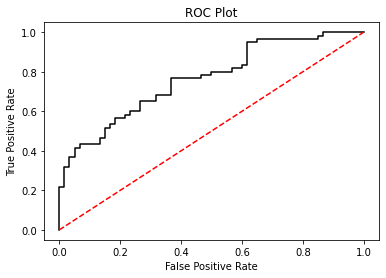

In [ ]:
train_inception("gen1")

Found 300 files belonging to 1 classes.
Found 300 files belonging to 1 classes.
Epoch 1/2
16/16 [==============================] - 14s 398ms/step - loss: 0.5959 - accuracy: 0.6771 - val_loss: 0.6462 - val_accuracy: 0.6750
Epoch 2/2
16/16 [==============================] - 5s 312ms/step - loss: 0.1943 - accuracy: 0.9458 - val_loss: 0.5258 - val_accuracy: 0.7500


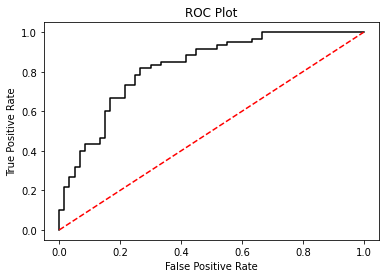

In [ ]:
train_inception("gen2")

Based on the accuracy scores returned from training the Inception model on real and fake Monet paintings, it appears that Gen1 is the better model.

### Hyperparameter tuning

Will higher generator learning rates boost the performance of the Gan1 model? Let us find out.

In [ ]:
gan1_lr = get_gan(
        paintings = monet_imgs,
        photos = photos,
        gen_g = build_gen1("gen_G"),
        gen_f = build_gen1("gen_F"),
        disc_x = build_disc("disc_X"),
        disc_y = build_disc("disc_Y"),
        epocs = 50,
        lr_g = 1e-3,
        lr_f = 1e-3
)

Found 300 files belonging to 1 classes.
Found 300 files belonging to 1 classes.
Epoch 1/2
16/16 [==============================] - 14s 398ms/step - loss: 0.5415 - accuracy: 0.7146 - val_loss: 1.0174 - val_accuracy: 0.5000
Epoch 2/2
16/16 [==============================] - 5s 313ms/step - loss: 0.1730 - accuracy: 0.9479 - val_loss: 1.4842 - val_accuracy: 0.5000


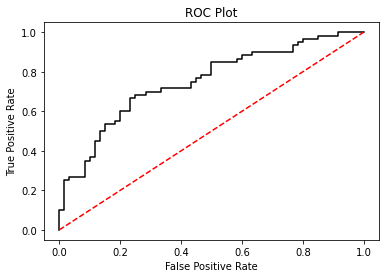

In [ ]:
train_inception("gan1_lr")

It appears that training with a higher learning rate improved model performance.

It appears that there is room for improvement. In fact, none of these images even looks like a painting.

Found 300 files belonging to 1 classes.


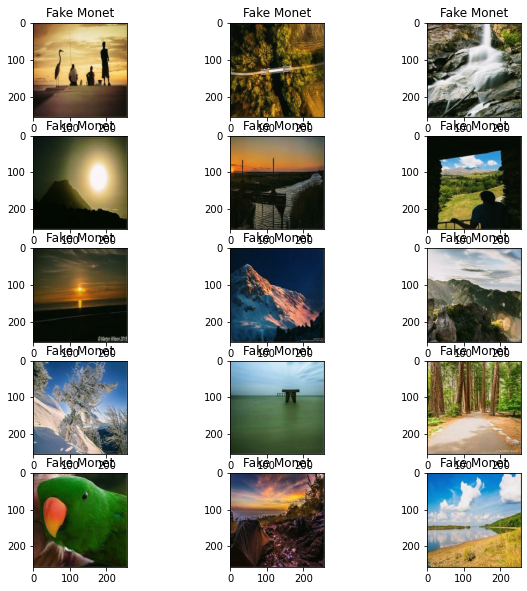

In [ ]:
gen1_imgs = get_imgs("gan1_lr", 300)
gen1_imgs = next(iter(gen1_imgs))
plt.figure(figsize=(10,10))
for (i,img) in enumerate(gen1_imgs[:15]):
  plt.subplot(5, 3, i+1)
  plt.title("Fake Monet")
  plt.imshow(img / 255.)

## Style GAN Approach

Let us take a different approach to generating Monet-esque images. It would be ideal if there was a way to transfer the style of one image over to another. Luckily, there is a method of doing this with a style GAN!  

To put it simply, a style GAN uses features learned in one image and applies them to another. A pretrained model is used below to transfer the style of each of the 300 monet images to 30 photos. A well-trained inception model is used to select the most realistic fake Monet images.

In [ ]:
monet = np.array(["{}/{}".format("gan-getting-started/monet_jpg", x) for x in os.listdir("gan-getting-started/monet_jpg")])
photos = np.array(["{}/{}".format("gan-getting-started/photo_jpg", x) for x in  os.listdir("gan-getting-started/photo_jpg")])

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.
Epoch 1/10
16/16 [==============================] - 30s 882ms/step - loss: 0.5942 - accuracy: 0.7021 - val_loss: 0.6445 - val_accuracy: 0.6500
Epoch 2/10
16/16 [==============================] - 12s 756ms/step - loss: 0.1793 - accuracy: 0.9500 - val_loss: 0.6388 - val_accuracy: 0.5750
Epoch 3/10
16/16 [==============================] - 12s 756ms/step - loss: 0.0965 - accuracy: 0.9875 - val_loss: 0.5572 - val_accuracy: 0.6667
Epoch 4/10
16/16 [==============================] - 13s 788ms/step - loss: 0.0810 - accuracy: 0.9833 - val_loss: 0.5239 - val_accuracy: 0.6583
Epoch 5/10
16/16 [==============================] - 12s 757ms/step - loss: 0.0376 - accuracy: 0.9979 - val_loss: 0.4279 - val_accuracy: 0.7500
Epoch 6/10
16/16 [==============================] - 12s 778ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.3659 - val_accuracy: 0.8083
Epoch 7/10
16/16 [==============================] - 13s 806ms

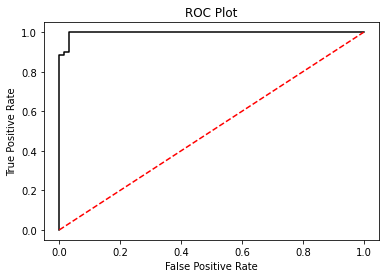

In [ ]:
incept_model = train_inception("gan-getting-started/photo_jpg", 10)

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [ ]:
dir_name = "images"
i = 0
os.system("mkdir {}".format(dir_name))
os.system("rm {}/*.jpg".format(dir_name))


for photo in photos:
  if i > 30:
    break
  phot = cv2.imread(photo)
  p = tf.convert_to_tensor([phot], dtype=tf.float32) / 255.

  styles = []
  for (j, mon) in enumerate(monet):
    mon = cv2.imread(mon)
    m = tf.convert_to_tensor([mon], dtype=tf.float32) / 255.
    stylized_image = hub_model(p, m)[0][0]
    styles.append(stylized_image)
  styles =  np.array(styles)
  pred = incept_model.predict(styles).reshape(-1)
  
  i += 1
  best = styles[np.where(pred == max(pred))]
  save_img('{}/img_{}.jpg'.format(dir_name, i), array_to_img(best[0]))
  print(max(pred), min(pred)) #probability of being a Monet painting extremes, choose the fake with highest prob


0.99211484 0.0074312566
0.99469984 0.029176975
0.9909021 0.0065719
0.99509466 0.012399131
0.99365497 0.039102834
0.9870272 0.024731154
0.99056566 0.031729616


These images are a lot better! If anything they at least look like paintings. According to the Inception model, these are indistinguishable from Monet paintings.

Found 31 files belonging to 1 classes.


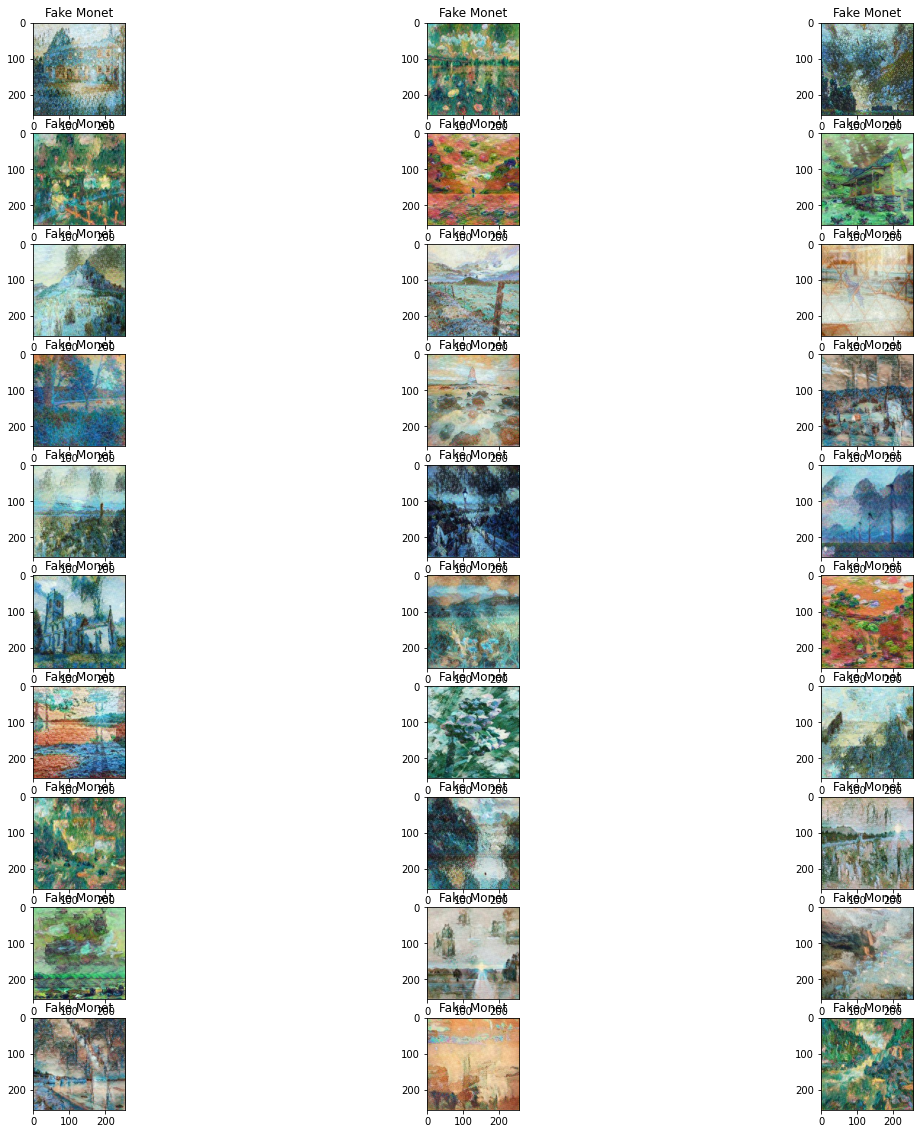

In [ ]:
all_fakes = get_imgs("images", 30) 
fakes = next(iter(all_fakes))

plt.figure(figsize=(20,20))
for (i,img) in enumerate(fakes):
  plt.subplot(10, 3, i+1)
  plt.title("Fake Monet")
  plt.imshow(img / 255.)

## Conclusion

The Gan1 model, which was built using a simple generator and trained with a high learning rate proved to be the best performing CycleGAN model. After two epocs, the inception model could still not differentiate between the fake, generated images and the true Monet paintings given that the validation accuracy was 0.5.

Increasing the learning rate improved model performance. It is generally a best practice to train generators with a higher learning rate than discriminators. This gives them a much needed head start. However, the generated images still looked like photographs. I suspect that this is because there wasn't enough data to allow the model to learn the mappings between the distribution of Monet paintings to the distribution of photos.

The Style GAN was, by far, the best performing model, based on the quality of the generated images. To quantify this, the best fake images are incorrectly classified as being Monet paintings with a >0.99 probability, according to an Inception model that was trained to differentiate between photos and Monet paintings. This method's success is likely due to the sophisticated architecture of the pre-trained Style GAN used in this study.